In [6]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import os
import dataloader
import architecture
import metrics
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
import pywt

c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Using TensorFlow backend


c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_scan():
    for path in train_brains:
        path = dataloader.extend_path_from_last_part(path)
        t1 = nib.load(f'{path}_t1.nii').get_fdata(dtype=X_DTYPE)
        t1ce = nib.load(f'{path}_t1ce.nii').get_fdata(dtype=X_DTYPE)
        t2 = nib.load(f'{path}_t2.nii').get_fdata(dtype=X_DTYPE)
        flair = nib.load(f'{path}_flair.nii').get_fdata(dtype=X_DTYPE)
        seg = nib.load(f'{path}_seg.nii').get_fdata(dtype=X_DTYPE)

        batch_X = np.zeros((dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE)
        batch_Y = np.zeros((dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE), dtype=Y_DTYPE)

        for i in range(dataloader.BRAIN_FRAMES):
            batch_X[i, :, :, 0] = cv2.resize(t1[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
            batch_X[i, :, :, 1] = cv2.resize(t1ce[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
            batch_X[i, :, :, 2] = cv2.resize(t2[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
            batch_X[i, :, :, 3] = cv2.resize(flair[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
            y_map = dataloader.DataGenerator._map_labels(seg[:, :, i])
            batch_Y[i, :, :] = cv2.resize(y_map, (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))

        batch_Y = tf.one_hot(batch_Y, 4, dtype=Y_DTYPE)
        batch_X = batch_X/MAX_VALUE

        yield batch_X, batch_Y

In [41]:
import tensorflow as tf
import numpy as np
import pywt

def wavelet_pooling(inputs, wavelet='haar'):
    def wavelet_transform(image):
        coeffs2 = pywt.dwt2(image, wavelet)
        LL, (LH, HL, HH) = coeffs2
        return LL.astype(np.float32)

    # Apply wavelet transform to each channel separately
    channels = tf.split(inputs, inputs.shape[-1], axis=-1)
    pooled_channels = [tf.numpy_function(wavelet_transform, [tf.squeeze(channel)], tf.float32) for channel in channels]
    pooled = tf.stack(pooled_channels, axis=-1)
    
    return pooled

def inverse_wavelet_pooling(inputs, original_shape, wavelet='haar'):
    def inverse_wavelet_transform(LL, shape):
        coeffs2 = (LL, (np.zeros_like(LL), np.zeros_like(LL), np.zeros_like(LL)))
        return pywt.idwt2(coeffs2, wavelet)[:shape[0], :shape[1]].astype(np.float32)

    # Apply inverse wavelet transform to each channel separately
    channels = tf.split(inputs, inputs.shape[-1], axis=-1)
    restored_channels = [
        tf.numpy_function(inverse_wavelet_transform, [tf.squeeze(channel), original_shape[1:3]], tf.float32)
        for channel in channels
    ]
    restored = tf.stack(restored_channels, axis=-1)
    
    return restored

# Example usage
input_tensor = tf.random.normal([1, 256, 256, 3])  # Example input tensor with batch size 1 and 3 channels
original_shape = input_tensor.shape
pooled_tensor = wavelet_pooling(input_tensor)
restored_tensor = inverse_wavelet_pooling(pooled_tensor, original_shape)

print(f"Pooled tensor shape: {pooled_tensor.shape}")
print(f"Restored tensor shape: {restored_tensor.shape}")


Pooled tensor shape: (128, 128, 3)
Restored tensor shape: (256, 256, 3)


In [54]:
pywt.wavelist()[-20:]

['shan',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',
 'sym14',
 'sym15',
 'sym16',
 'sym17',
 'sym18',
 'sym19',
 'sym20']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


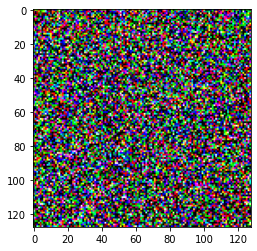

In [5]:
plt.imshow(pooled_tensor)
plt.show()

In [7]:
ROOT_DIR = '.'
DATA_DIR = 'BRATS_2018'
LABELED_DIR = 'MICCAI_BraTS_2018_Data_Training'
UNLABELED_DIR = 'MICCAI_BraTS_2018_Data_Validation'
LABELED_PATH = os.path.join(ROOT_DIR, DATA_DIR, LABELED_DIR)
UNLABELED_PATH = os.path.join(ROOT_DIR, DATA_DIR, UNLABELED_DIR)

BATCH_SIZE = 32
BRAIN_SLICES = 9
NUM_CLASSES = 4
X_DTYPE = np.float32
Y_DTYPE = np.uint8
MAX_VALUE = 32767

In [15]:
def _spectral_crop(input, oheight, owidth):
    cutoff_freq_h = int(np.ceil(oheight / 2))
    cutoff_freq_w = int(np.ceil(owidth / 2))

    if oheight % 2 == 1:
        if owidth % 2 == 1:
            top_left = input[:, :cutoff_freq_h, :cutoff_freq_w]
            top_right = input[:, :cutoff_freq_h, -(cutoff_freq_w-1):]
            bottom_left = input[:, -(cutoff_freq_h-1):, :cutoff_freq_w]
            bottom_right = input[:, -(cutoff_freq_h-1):, -(cutoff_freq_w-1):]
        else:
            top_left = input[:, :cutoff_freq_h, :cutoff_freq_w]
            top_right = input[:, :cutoff_freq_h, -cutoff_freq_w:]
            bottom_left = input[:, -(cutoff_freq_h-1):, :cutoff_freq_w]
            bottom_right = input[:, -(cutoff_freq_h-1):, -cutoff_freq_w:]
    else:
        if owidth % 2 == 1:
            top_left = input[:, :cutoff_freq_h, :cutoff_freq_w]
            top_right = input[:, :cutoff_freq_h, -(cutoff_freq_w-1):]
            bottom_left = input[:, -cutoff_freq_h:, :cutoff_freq_w]
            bottom_right = input[:, -cutoff_freq_h:, -(cutoff_freq_w-1):]
        else:
            top_left = input[:, :cutoff_freq_h, :cutoff_freq_w]
            top_right = input[:, :cutoff_freq_h, -cutoff_freq_w:]
            bottom_left = input[:, -cutoff_freq_h:, :cutoff_freq_w]
            bottom_right = input[:, -cutoff_freq_h:, -cutoff_freq_w:]

    top_combined = tf.concat((top_left, top_right), axis=-1)
    bottom_combined = tf.concat((bottom_left, bottom_right), axis=-1)
    all_together = tf.concat((top_combined, bottom_combined), axis=-2)

    return all_together

def _spectral_pad(input, output, oheight, owidth):
    cutoff_freq_h = int(np.ceil(oheight / 2))
    cutoff_freq_w = int(np.ceil(owidth / 2))

    pad = tf.zeros_like(input)

    if oheight % 2 == 1:
        if owidth % 2 == 1:
            pad[:, :cutoff_freq_h, :cutoff_freq_w] = output[:, :cutoff_freq_h, :cutoff_freq_w]
            pad[:, :cutoff_freq_h, -(cutoff_freq_w-1):] = output[:, :cutoff_freq_h, -(cutoff_freq_w-1):]
            pad[:, -(cutoff_freq_h-1):, :cutoff_freq_w] = output[:, -(cutoff_freq_h-1):, :cutoff_freq_w]
            pad[:, -(cutoff_freq_h-1):, -(cutoff_freq_w-1):] = output[:, -(cutoff_freq_h-1):, -(cutoff_freq_w-1):]
        else:
            pad[:, :cutoff_freq_h, :cutoff_freq_w] = output[:, :cutoff_freq_h, :cutoff_freq_w]
            pad[:, :cutoff_freq_h, -cutoff_freq_w:] = output[:, :cutoff_freq_h, -cutoff_freq_w:]
            pad[:, -(cutoff_freq_h-1):, :cutoff_freq_w] = output[:, -(cutoff_freq_h-1):, :cutoff_freq_w]
            pad[:, -(cutoff_freq_h-1):, -cutoff_freq_w:] = output[:, -(cutoff_freq_h-1):, -cutoff_freq_w:]
    else:
        if owidth % 2 == 1:
            pad[:, :cutoff_freq_h, :cutoff_freq_w] = output[:, :cutoff_freq_h, :cutoff_freq_w]
            pad[:, :cutoff_freq_h, -(cutoff_freq_w-1):] = output[:, :cutoff_freq_h, -(cutoff_freq_w-1):]
            pad[:, -cutoff_freq_h:, :cutoff_freq_w] = output[:, -cutoff_freq_h:, :cutoff_freq_w]
            pad[:, -cutoff_freq_h:, -(cutoff_freq_w-1):] = output[:, -cutoff_freq_h:, -(cutoff_freq_w-1):]
        else:
            pad[:, :cutoff_freq_h, :cutoff_freq_w] = output[:, :cutoff_freq_h, :cutoff_freq_w]
            pad[:, :cutoff_freq_h, -cutoff_freq_w:] = output[:, :cutoff_freq_h, -cutoff_freq_w:]
            pad[:, -cutoff_freq_h:, :cutoff_freq_w] = output[:, -cutoff_freq_h:, :cutoff_freq_w]
            pad[:, -cutoff_freq_h:, -cutoff_freq_w:] = output[:, -cutoff_freq_h:, -cutoff_freq_w:]

    return pad

def DiscreteHartleyTransform(input):
    fft = tf.signal.fft2d(tf.cast(input, tf.complex64))
    dht = tf.math.real(fft) - tf.math.imag(fft)
    return dht

@tf.custom_gradient
def SpectralPoolingFunction(input, oheight, owidth):
    dht = DiscreteHartleyTransform(input)
    all_together = _spectral_crop(dht, oheight, owidth)
    dht = DiscreteHartleyTransform(all_together)

    def grad(grad_output):
        dht_grad = DiscreteHartleyTransform(grad_output)
        grad_input = _spectral_pad(input, dht_grad, oheight, owidth)
        grad_input = DiscreteHartleyTransform(grad_input)
        return grad_input, None, None

    return dht, grad

class SpectralPool2d(tf.keras.layers.Layer):
    def __init__(self, scale_factor):
        super(SpectralPool2d, self).__init__()
        self.scale_factor = scale_factor

    def call(self, inputs):
        H, W = inputs.shape[-2], inputs.shape[-1]
        h = int(np.ceil(H * self.scale_factor[0]))
        w = int(np.ceil(W * self.scale_factor[1]))
        return SpectralPoolingFunction(inputs, h, w)

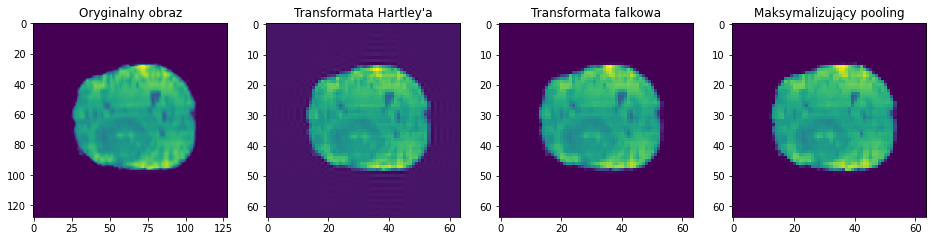

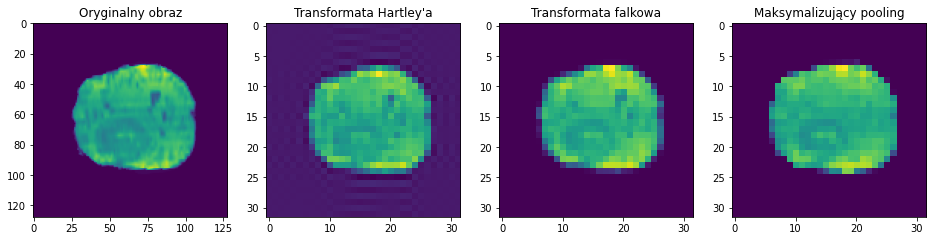

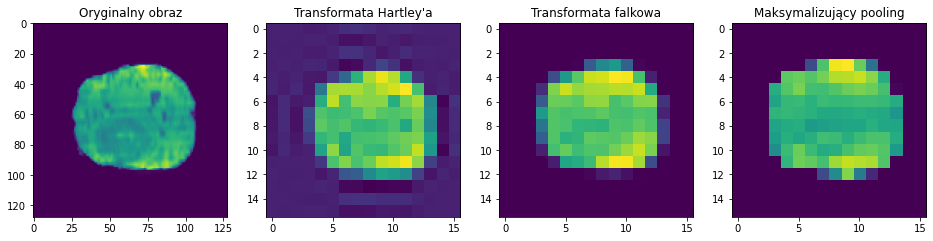

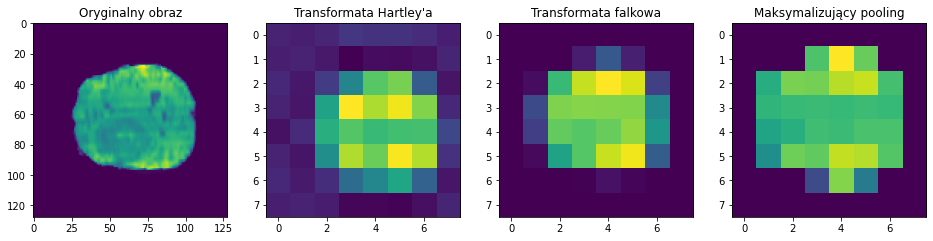

In [46]:
def wavelet_transform(image):
    """Perform a 2D wavelet transform."""
    coeffs = pywt.dwt2(image, wavelet='haar')
    return coeffs[0]

def inverse_wavelet_transform(coeffs):
    """Perform an inverse 2D wavelet transform."""
    image_reconstructed = pywt.idwt2(coeffs, wavelet='haar')
    return image_reconstructed

for batch_X, batch_Y in get_train_scan():

    image = batch_X[77, :, :, 0]
    hartley_image = np.expand_dims(batch_X[77, :, :, 0], axis=[0])
    wavelet_image = batch_X[77, :, :, 0]
    pooling_image = np.expand_dims(image, axis=[0, -1])

    max_pooling = tf.keras.layers.MaxPool2D()

    for i in range(1, 5):

        plt.figure(figsize=(16, 6))

        plt.subplot(1, 4, 1)
        plt.title('Oryginalny obraz')
        plt.imshow(image)


        hartley_image = SpectralPool2d(scale_factor=(0.5, 0.5))(hartley_image)

        plt.subplot(1, 4, 2)
        plt.title("Transformata Hartley'a")
        plt.imshow(tf.squeeze(hartley_image))


        wavelet_image = wavelet_transform(wavelet_image)

        plt.subplot(1, 4, 3)
        plt.title('Transformata falkowa')
        plt.imshow(tf.squeeze(wavelet_image))


        pooling_image = max_pooling(pooling_image)

        plt.subplot(1, 4, 4)
        plt.title('Maksymalizujący pooling')
        plt.imshow(tf.squeeze(pooling_image))

        plt.show()

    break

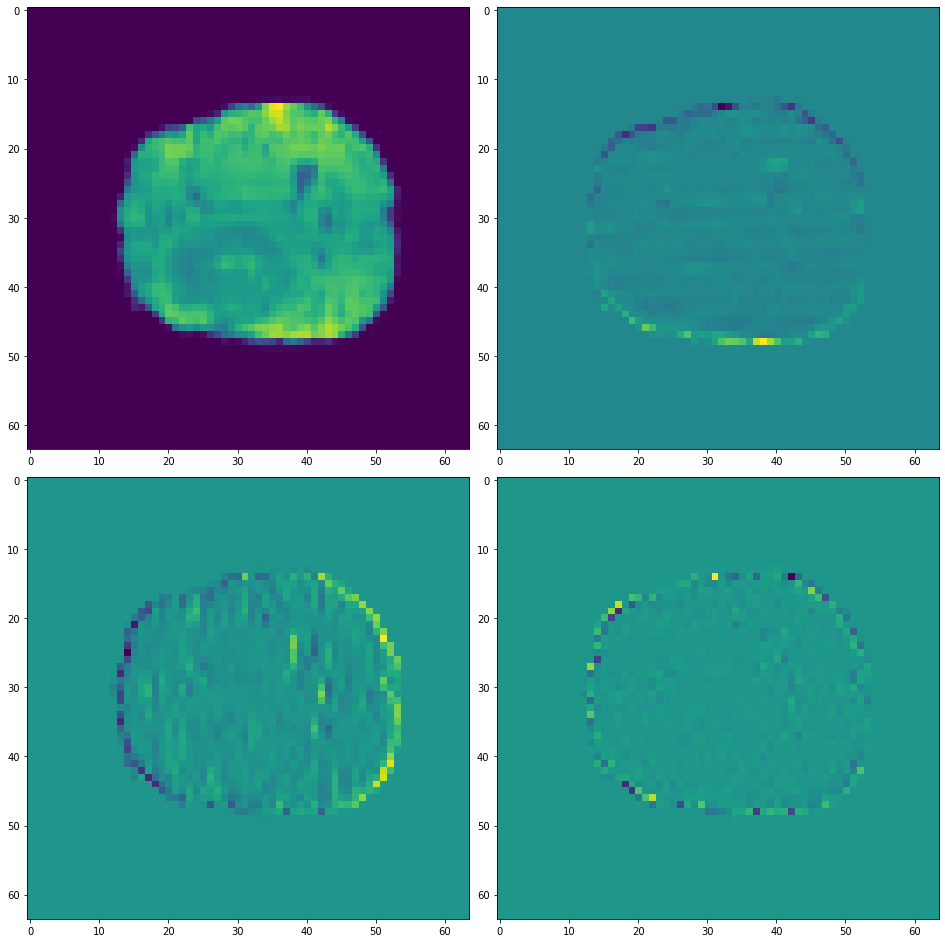

In [14]:
def wavelet_transform(image):
    """Perform a 2D wavelet transform."""
    coeffs = pywt.dwt2(image, wavelet='haar')
    return coeffs

def inverse_wavelet_transform(coeffs):
    """Perform an inverse 2D wavelet transform."""
    image_reconstructed = pywt.idwt2(coeffs, wavelet='haar')
    return image_reconstructed

for batch_X, batch_Y in get_train_scan():

    image = batch_X[77, :, :, 0]
    trans = wavelet_transform(image)

    fig, axs = plt.subplots(2, 2, figsize=(13, 13), constrained_layout=True)

    axs[0, 0].imshow(trans[0])
    axs[0, 1].imshow(trans[1][0])
    axs[1, 0].imshow(trans[1][1])
    axs[1, 1].imshow(trans[1][2])

    plt.show()
    break

In [18]:
class DWT_Layer(tf.keras.layers.Layer):
    def __init__(self, wavelet_name='haar', **kwargs):
        super(DWT_Layer, self).__init__(**kwargs)
        self.wavelet_name = wavelet_name

    def build(self, input_shape):
        # Utwórz warstwę DWT w metodzie build
        self.dwt_layer = DWT.DWT(wavelet_name=self.wavelet_name, concat=0)
        super(DWT_Layer, self).build(input_shape)

    def call(self, inputs):
        # Użyj warstwy DWT
        trans = self.dwt_layer(inputs)
        
        # Zachowaj tylko kanały LL (pierwsze 1/4 kanałów)
        trans_LL = trans[:, :, :, :inputs.shape[-1]]

        return trans_LL

    def compute_output_shape(self, input_shape):
        # Określ rozmiar wyjścia
        return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, input_shape[3])

In [ ]:

for batch_X, batch_Y in get_train_scan():

    trans = DWT_Layer()(batch_X)

.    print('elo')
    break

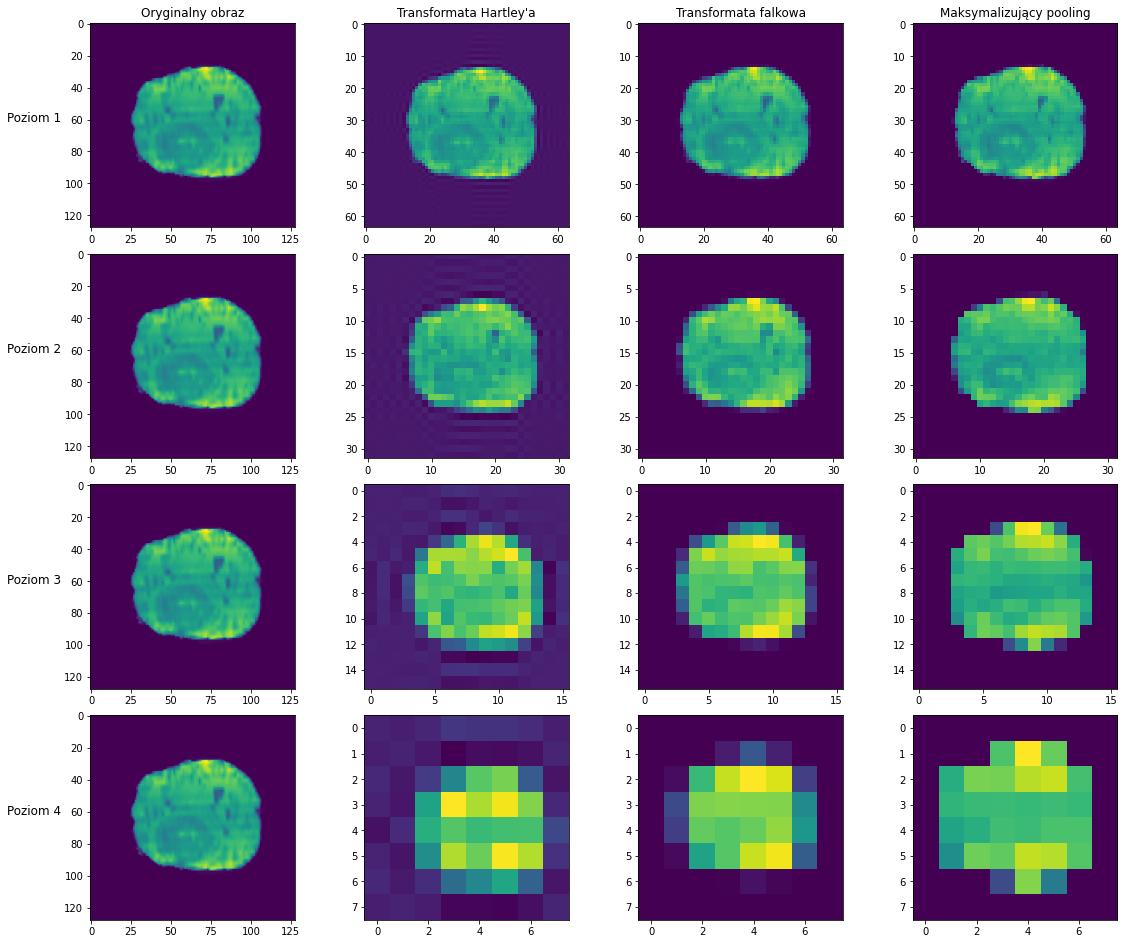

In [38]:
def wavelet_transform(image):
    """Perform a 2D wavelet transform."""
    coeffs = pywt.dwt2(image, wavelet='haar')
    return coeffs[0]

def inverse_wavelet_transform(coeffs):
    """Perform an inverse 2D wavelet transform."""
    image_reconstructed = pywt.idwt2(coeffs, wavelet='haar')
    return image_reconstructed

for batch_X, batch_Y in get_train_scan():

    image = batch_X[77, :, :, 0]
    hartley_image = np.expand_dims(batch_X[77, :, :, 0], axis=[0])
    wavelet_image = batch_X[77, :, :, 0]
    pooling_image = np.expand_dims(image, axis=[0, -1])

    max_pooling = tf.keras.layers.MaxPool2D()

    fig, axs = plt.subplots(4, 4, figsize=(16, 13), constrained_layout=True)

    for i in range(4):

        axs[i][0].imshow(image)
        if i == 0:
            axs[i][0].set_title('Oryginalny obraz')
        axs[i][0].set_ylabel(f'Poziom {i+1}', rotation=0, size='large', labelpad=30)

        hartley_image = SpectralPool2d(scale_factor=(0.5, 0.5))(hartley_image)

        
        axs[i][1].imshow(tf.squeeze(hartley_image))
        if i == 0:
            axs[i][1].set_title("Transformata Hartley'a")


        wavelet_image = wavelet_transform(wavelet_image)

        axs[i][2].imshow(tf.squeeze(wavelet_image))
        if i == 0:
            axs[i][2].set_title('Transformata falkowa')


        pooling_image = max_pooling(pooling_image)

        axs[i][3].imshow(tf.squeeze(pooling_image))
        if i == 0:
            axs[i][3].set_title('Maksymalizujący pooling')

    plt.show()

    break

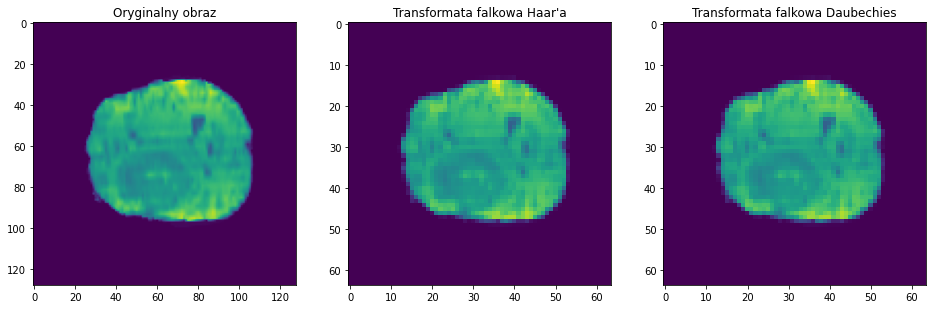

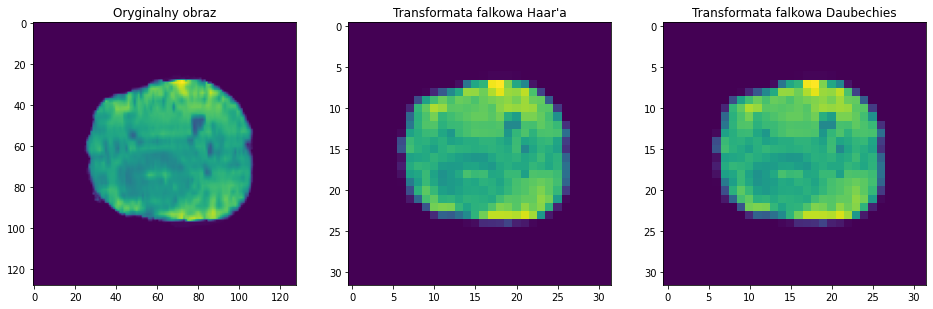

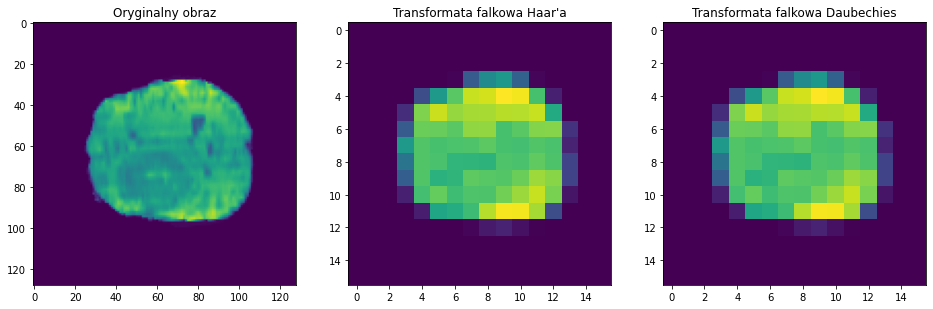

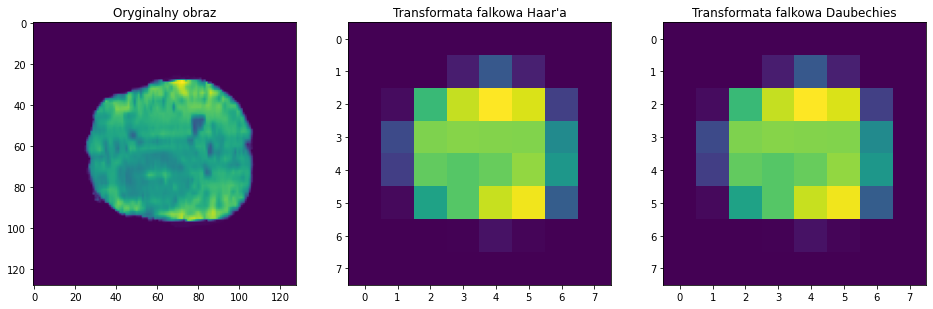

In [45]:
def wavelet_transform(image, wavelet):
    """Perform a 2D wavelet transform."""
    coeffs = pywt.dwt2(image, wavelet=wavelet)
    return coeffs[0]

def inverse_wavelet_transform(coeffs):
    """Perform an inverse 2D wavelet transform."""
    image_reconstructed = pywt.idwt2(coeffs, wavelet='db1')
    return image_reconstructed

for batch_X, batch_Y in get_train_scan():

    image = batch_X[77, :, :, 0]
    hartley_image = np.expand_dims(batch_X[77, :, :, 0], axis=[0])
    wavelet_image_1 = batch_X[77, :, :, 0]
    wavelet_image_2 = batch_X[77, :, :, 0]

    max_pooling = tf.keras.layers.MaxPool2D()

    for i in range(1, 5):

        plt.figure(figsize=(16, 6))

        plt.subplot(1, 3, 1)
        plt.title('Oryginalny obraz')
        plt.imshow(image)


        wavelet_image_1 = wavelet_transform(wavelet_image_1, 'haar')

        plt.subplot(1, 3, 2)
        plt.title("Transformata falkowa Haar'a")
        plt.imshow(tf.squeeze(wavelet_image_1))


        wavelet_image_2 = wavelet_transform(wavelet_image_2, 'db1')

        plt.subplot(1, 3, 3)
        plt.title("Transformata falkowa Daubechies")
        plt.imshow(tf.squeeze(wavelet_image_2))

        plt.show()

    break

In [9]:
from importlib import reload
reload(architecture)
import architecture

In [10]:
for batch_X, batch_Y in get_train_scan():

    elo = architecture.WaveletPooling2D()(batch_X)

    break

In [8]:
paths, sizes = dataloader.load_dataset_paths(LABELED_PATH, UNLABELED_PATH)

In [9]:
train_brains, val_brains, test_brains, unlabeled_brains = paths

In [10]:
hgg_train_size, lgg_train_size, hgg_val_size, lgg_val_size = sizes 

In [11]:
hgg_train_size, lgg_train_size

(142, 50)

In [9]:
len(train_brains), len(val_brains), len(test_brains)

(192, 49, 44)

In [36]:
reload(dataloader)
import dataloader

In [7]:
test_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[test_brains, MAX_VALUE, dataloader.BRAIN_FRAMES, 1, False, False, True, 0, hgg_train_size, lgg_train_size])

In [ ]:
for elem in test_dataset.take(1):
    for i in range(dataloader.BRAIN_FRAMES):
        plt.imshow(elem[0][i, :, :, 0])
        plt.show()
        plt.imshow(elem[1][i, :, :, 1])
        plt.show()

In [15]:
model.evaluate(test_dataset)

44/44 [==============================] - 173s 4s/step - loss: 0.9932 - accuracy: 0.2947 - one_hot_mean_io_u: 0.0778 - one_hot_io_u: 0.2948 - one_hot_io_u_1: 0.0087 - one_hot_io_u_2: 0.0045 - one_hot_io_u_3: 0.0034 - precision: 0.0000e+00 - precision_1: 0.0000e+00 - precision_2: 0.0000e+00 - precision_3: 0.0000e+00 - recall: 0.0000e+00 - recall_1: 0.0000e+00 - recall_2: 0.0000e+00 - recall_3: 0.0000e+00


[0.9932040572166443,
 0.29465726017951965,
 0.07784107327461243,
 0.2947508692741394,
 0.008732856251299381,
 0.0044817146845161915,
 0.003398865694180131,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [8]:
len(train_brains), len(val_brains), len(test_brains), len(unlabeled_brains)

(192, 49, 44, 66)

In [8]:
# all_brains = train_brains + val_brains + test_brains + unlabeled_brains

In [9]:
# dataloader.find_max_per_channel(all_brains)

Pobieranie warstwowo-losowe

In [22]:
train_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[train_brains, MAX_VALUE, BATCH_SIZE, BRAIN_SLICES, True, True, False, 22, hgg_train_size, lgg_train_size])


val_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[val_brains, MAX_VALUE, BATCH_SIZE, BRAIN_SLICES, True, True, False, 22, hgg_val_size, lgg_val_size])

train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.repeat().prefetch(tf.data.AUTOTUNE)

In [ ]:
for elem in train_dataset.take(1):
    for i in range(BATCH_SIZE):
        plt.imshow(elem[0][i, :, :, 0])
        plt.show()
        plt.imshow(elem[1][i, :, :, 1])
        plt.show()

Pobieranie losowe

In [24]:
train_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[train_brains, MAX_VALUE, BATCH_SIZE, BRAIN_SLICES, True, False, False, 22, hgg_train_size, lgg_train_size])

In [ ]:
for elem in train_dataset.take(1):
    for i in range(0, BATCH_SIZE):
        plt.imshow(elem[0][i, :, :, 0])
        plt.show()
        plt.imshow(elem[1][i, :, :, 1])
        plt.show()

Pobieranie warstwowo-sekwencyjne

In [13]:
from importlib import reload
reload(dataloader)
import dataloader

In [26]:
train_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=Y_DTYPE)
), args=[train_brains, MAX_VALUE, BATCH_SIZE, BRAIN_SLICES, False, False, False, 22, hgg_train_size, lgg_train_size])

In [ ]:
for elem in train_dataset.take(1):
    for i in range(0, BATCH_SIZE):
        plt.imshow(elem[0][i, :, :, 0])
        plt.show()
        plt.imshow(elem[1][i, :, :, 1])
        plt.show()

In [ ]:
#from IPython.display import clear_output
i = 0
for elem in train_dataset.take(8):
    clear_output(wait=True)
    if i == 7:
        for i in range(BATCH_SIZE):
            plt.imshow(elem[0][i, :, :, 0])
            plt.show()
            plt.imshow(elem[1][i, :, :, 1])
            plt.show()
    i += 1

Zbiór testowy

In [11]:
from collections import Counter

c = Counter()
for path in test_brains:
    path = dataloader.extend_path_from_last_part(path)
    seg = nib.load(f'{path}_seg.nii').get_fdata(dtype=X_DTYPE)
    batch_Y = np.zeros((dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE), dtype=Y_DTYPE)
    for i in range(dataloader.BRAIN_FRAMES):
        y_map = dataloader.DataGenerator._map_labels(seg[:, :, i])
        batch_Y[i, :, :] = cv2.resize(y_map, (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
    c.update(batch_Y.flatten())
    
print(c)

Counter({0: 110431511, 1: 689024, 3: 334433, 2: 283912})


In [ ]:
from sklearn.metrics import roc_curve
import nibabel as nib
import cv2

iou_zero, iou_edema, iou_core, iou_necrotic = [], [], [], []
calculate_roc = False
global_iou_0 = tf.keras.metrics.OneHotIoU(NUM_CLASSES, [0])
global_iou_1 = tf.keras.metrics.OneHotIoU(NUM_CLASSES, [1])
global_iou_2 = tf.keras.metrics.OneHotIoU(NUM_CLASSES, [2])
global_iou_3 = tf.keras.metrics.OneHotIoU(NUM_CLASSES, [3])

if calculate_roc:
    roc_curves = []
    common_fpr = np.linspace(0, 1, 100)
    mean_tpr = {f'class_{i}': np.zeros_like(common_fpr) for i in range(4)}
    curve_counter = {0: 0, 1: 0, 2: 0, 3: 0}

for path in test_brains:
    path = dataloader.extend_path_from_last_part(path)
    t1 = nib.load(f'{path}_t1.nii').get_fdata(dtype=X_DTYPE)
    t1ce = nib.load(f'{path}_t1ce.nii').get_fdata(dtype=X_DTYPE)
    t2 = nib.load(f'{path}_t2.nii').get_fdata(dtype=X_DTYPE)
    flair = nib.load(f'{path}_flair.nii').get_fdata(dtype=X_DTYPE)
    seg = nib.load(f'{path}_seg.nii').get_fdata(dtype=X_DTYPE)

    batch_X = np.zeros((dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE)
    batch_Y = np.zeros((dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE), dtype=Y_DTYPE)

    for i in range(dataloader.BRAIN_FRAMES):
        batch_X[i, :, :, 0] = cv2.resize(t1[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
        batch_X[i, :, :, 1] = cv2.resize(t1ce[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
        batch_X[i, :, :, 2] = cv2.resize(t2[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
        batch_X[i, :, :, 3] = cv2.resize(flair[:, :, i], (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))
        y_map = dataloader.DataGenerator._map_labels(seg[:, :, i])
        batch_Y[i, :, :] = cv2.resize(y_map, (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))

    batch_Y = tf.one_hot(batch_Y, 4, dtype=Y_DTYPE)
    batch_X = batch_X/MAX_VALUE

    y_pred = model.predict(batch_X)
    
    global_iou_0.update_state(batch_Y, y_pred)
    global_iou_1.update_state(batch_Y, y_pred)
    global_iou_2.update_state(batch_Y, y_pred)
    global_iou_3.update_state(batch_Y, y_pred)
    
    # Obliczanie IoU dla każdej klasy
    for frame_index in range(dataloader.BRAIN_FRAMES):
        
        for class_index in range(4):
            
            iou_metric = tf.keras.metrics.OneHotIoU(NUM_CLASSES, [class_index])
            iou_metric.update_state(batch_Y[frame_index], y_pred[frame_index])
            iou_value = iou_metric.result().numpy()
            
            if np.any(batch_Y[frame_index, :, :, class_index] == 1) or np.any(y_pred[frame_index, :, :, class_index] > 0.5):
                is_class_frames = True
                
            if calculate_roc:
                fpr, tpr, _ = roc_curve(y_true[frame_index].flatten(), y_pred[frame_index, :, :, class_index].flatten())
                mean_tpr[f'class_{class_index}'] += np.interp(common_fpr, fpr, tpr)
                curve_counter[class_index] += 1

            if class_index == 0:
                if is_class_frames:
                    iou_zero.append(iou_value)
                else:
                    iou_zero.append(np.nan)
            elif class_index == 1:
                if is_class_frames:
                    iou_edema.append(iou_value)
                else:
                    iou_edema.append(np.nan)
            elif class_index == 2:
                if is_class_frames:
                    iou_core.append(iou_value)
                else:
                    iou_core.append(np.nan)
            elif class_index == 3:
                if is_class_frames:
                    iou_necrotic.append(iou_value)
                else:
                    iou_necrotic.append(np.nan)
                    
            is_class_frames = False

if calculate_roc:
    for class_index in range(4):
        mean_tpr[f'class_{class_index}'] /= curve_counter[class_index]
        roc_curves.append(mean_tpr[f'class_{class_index}'])

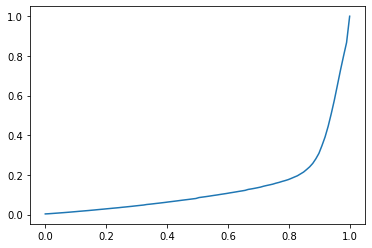

In [91]:
auc_0 = auc(common_fpr, mean_tpr['class_0'])
plt.plot(common_fpr, roc_curves[4][0], label=f'AUC {auc_0}')

(array([892., 606., 521., 386., 278., 147.,  65.,  66.,  12.,  18.]),
 array([6.1035156e-05, 1.1206055e-02, 2.2351075e-02, 3.3496093e-02,
        4.4641115e-02, 5.5786133e-02, 6.6931151e-02, 7.8076169e-02,
        8.9221194e-02, 1.0036621e-01, 1.1151123e-01], dtype=float32),
 <BarContainer object of 10 artists>)

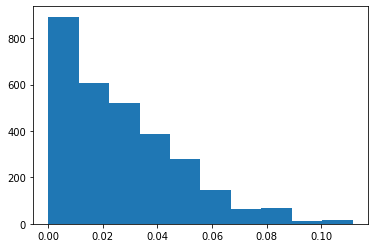

In [82]:
plt.hist(iou_zero)

In [34]:
train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)

In [13]:
val_dataset = val_dataset.repeat().prefetch(tf.data.AUTOTUNE)

In [11]:
from keras import backend as K

Wagi

In [1]:
poczatkowe_wagi = [0.00109971, 0.1458139, 0.5603247, 0.29276177]
globalne_wagi = [0.00098611, 0.15070848, 0.45178135, 0.39652405]
globalne_wagi_focal = [0.2528032, 38.63607146, 115.8200004, 101.65407565]
matched_wagi_8s_22 = [0.00106513, 0.11376679, 0.36450973, 0.27065834]

In [18]:
train_test_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=X_DTYPE)
), args=[train_brains, MAX_VALUE, BATCH_SIZE, 8, True, True, False, 22, hgg_train_size, lgg_train_size])

w = 0
for elem in train_test_dataset.take(len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE)):
    class_counts = K.sum(elem[1], axis=[0, 1, 2])
    class_weights = tf.math.reciprocal(class_counts)
    class_weights = np.nan_to_num(class_weights.numpy())

    w += class_weights/K.sum(class_weights, keepdims=True)

print(w/(len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE)))

tf.Tensor([0.00106513 0.11376679 0.36450973 0.27065834], shape=(4,), dtype=float32)


In [12]:
train_test_dataset = tf.data.Dataset.from_generator(dataloader.build_data_generator, output_signature=(
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), dtype=X_DTYPE),
    tf.TensorSpec(shape=(BATCH_SIZE, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, NUM_CLASSES), dtype=X_DTYPE)
), args=[train_brains, MAX_VALUE, BATCH_SIZE, 9, True, True, False, 22, hgg_train_size, lgg_train_size])

w = 0
for elem in train_test_dataset.take(len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE)):
    class_counts = K.sum(elem[1], axis=[0, 1, 2])
    class_weights = tf.math.reciprocal(class_counts)
    class_weights = np.nan_to_num(class_weights.numpy())

    w += class_weights/K.sum(class_weights, keepdims=True)

print(w/(len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE)))

tf.Tensor([0.00090662 0.11002847 0.35678837 0.28227642], shape=(4,), dtype=float32)


In [10]:
import nibabel as nib
import cv2

from collections import Counter

c = Counter()

for path in train_brains:
    path = dataloader.extend_path_from_last_part(path)
    seg = nib.load(f'{path}_seg.nii').get_fdata(dtype=X_DTYPE)

    batch_Y = np.zeros((dataloader.BRAIN_FRAMES, dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE), dtype=Y_DTYPE)

    for i in range(dataloader.BRAIN_FRAMES):
        y_map = dataloader.DataGenerator._map_labels(seg[:, :, i])
        batch_Y[i, :, :] = cv2.resize(y_map, (dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE))

    c.update(batch_Y.flatten())    

In [11]:
c

Counter({0: 482181232, 1: 3155004, 2: 1052469, 3: 1199135})

In [9]:
class_amounts = [482181232, 3155004, 1052469, 1199135]
n_samples = sum(class_amounts)
n_classes = 4
focal_weights = []
for i in range(n_classes):
    focal_weights.append(round(n_samples / (n_classes * class_amounts[i]), 8))

print(focal_weights)

[0.2528032, 38.63607146, 115.8200004, 101.65407565]


In [10]:
normalized_focal_weights = [w / sum(focal_weights) for w in focal_weights]
print(normalized_focal_weights)

[0.0009861144104476047, 0.15070848323830324, 0.45178135170950107, 0.396524050641748]


In [4]:
elo = 1/482181232, 1/3155004, 1/1052469, 1/1199135
elo_sum = sum(elo)
for elem in elo:
    print(elem/elo_sum)

0.0009861144231586264
0.15070848323856195
0.45178135170878747
0.396524050629492


In [21]:
w = [0] * 4
w_recip_sum = 0
for class_index, class_count in c.items():
    w_recip = 1 / class_count
    w[class_index] = w_recip
    w_recip_sum += w_recip
w = [elem / w_recip_sum for elem in w]
print(w)

[0.0009861144231586266, 0.15070848323856192, 0.45178135170878747, 0.3965240506294919]


In [174]:
w = 0
for elem in train_dataset.take(len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE)):
    class_counts = K.sum(elem[1], axis=[0, 1, 2])
    class_weights = tf.math.reciprocal(class_counts)

    w += class_weights/K.sum(class_weights, keepdims=True)
print(w/(len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE)))

tf.Tensor([0.00109971 0.1458139  0.5603247  0.29276177], shape=(4,), dtype=float32)


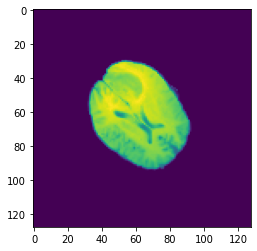

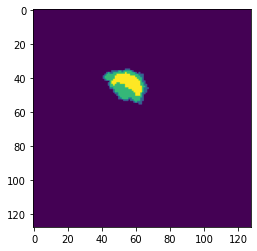

In [99]:
for elem in train_dataset.take(1):
    plt.imshow(elem[0][16, :, :, 0])
    plt.show()
    elo = tf.argmax(elem[1][16, :, :, :], axis=-1)
    plt.imshow(elo)
    plt.show()

In [70]:
class_weights = tf.math.reciprocal(np.array([518359, 3426, 993, 1510], dtype=np.float32))

In [71]:
class_weights

<tf.Tensor: shape=(4,), dtype=float32, numpy=
array([1.9291649e-06, 2.9188558e-04, 1.0070493e-03, 6.6225167e-04],
      dtype=float32)>

In [173]:
new_class_weights = class_weights/tf.reduce_sum(class_weights, keepdims=True)
new_class_weights

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.00098271, 0.14868484, 0.5129852 , 0.33734724], dtype=float32)>

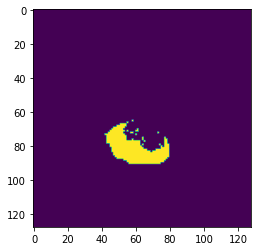

In [115]:
import matplotlib.pyplot as plt
plt.imshow(seg[0, :, :, 2])
plt.show()

In [ ]:
# Z losowaniem - 3.5s bez - 0.2s

In [7]:
from importlib import reload
reload(architecture)
import architecture

In [7]:
model = architecture.build_model((dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), NUM_CLASSES)

In [8]:
model = architecture.build_diunet((dataloader.IMAGE_SIZE, dataloader.IMAGE_SIZE, dataloader.CHANNELS), NUM_CLASSES)

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 4)]        0         []                            
                                                                                                  
 conv2d_148 (Conv2D)         (None, 128, 128, 10)         50        ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_156 (LeakyReLU  (None, 128, 128, 10)         0         ['conv2d_148[0][0]']          
 )                                                                                                
                                                                                                  
 conv2d_149 (Conv2D)         (None, 128, 128, 10)         910       ['leaky_re_lu_156[0][0]'

In [ ]:
model.get_layer('sequential').layers[0].weights

In [11]:
def scale_fn(x):
    return 1/(2.**(x-1))

steps_per_epoch = len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE)
val_steps_per_epoch = len(val_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4,
    maximal_learning_rate=1e-2,
    scale_fn=scale_fn,
    step_size=2 * steps_per_epoch
)

In [25]:
model.compile(loss=metrics.weighted_f1_loss, optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.00001), metrics=['accuracy', 
                                                                                               tf.keras.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[0]),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[1]),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[2]),
                                                                                               tf.keras.metrics.OneHotIoU(num_classes=NUM_CLASSES, target_class_ids=[3]),
                                                                                               tf.keras.metrics.Precision(class_id=0),
                                                                                               tf.keras.metrics.Precision(class_id=1),
                                                                                               tf.keras.metrics.Precision(class_id=2),
                                                                                               tf.keras.metrics.Precision(class_id=3),
                                                                                               tf.keras.metrics.Recall(class_id=0),
                                                                                               tf.keras.metrics.Recall(class_id=1),
                                                                                               tf.keras.metrics.Recall(class_id=2),
                                                                                               tf.keras.metrics.Recall(class_id=3)])

In [22]:
checkpoint_filepath = os.path.join(ROOT_DIR, 'checkpoints', 'model-{epoch:02d}-{val_one_hot_mean_io_u:.3f}')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_one_hot_mean_io_u',
    mode='max',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, restore_best_weights=True)

csv_logger_callback = tf.keras.callbacks.CSVLogger('brainTumor.log')

In [12]:
from importlib import reload
reload(architecture)
import architecture

In [14]:
class HaarWaveletLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(HaarWaveletLayer, self).__init__(**kwargs)

    def call(self, inputs):
        def haar_wavelet_transform(image):
            # image: [height, width, channels]
            transformed_channels = []
            for c in range(image.shape[-1]):
                coeffs2 = pywt.dwt2(image[:, :, c], 'haar')
                LL, (LH, HL, HH) = coeffs2
                transformed_channels.append(LL)
            return np.stack(transformed_channels, axis=-1).astype(X_DTYPE)

        def pywt_transform(inputs_numpy):
            transformed_images = [haar_wavelet_transform(image) for image in inputs_numpy]
            return np.stack(transformed_images, axis=0)

        # Apply tf.numpy_function
        output = tf.numpy_function(func=pywt_transform, inp=[inputs], Tout=X_DTYPE)
        
        # Set shape information manually
        batch_size, height, width, channels = inputs.shape
        output.set_shape((batch_size, height // 2, width // 2, channels))
        
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, input_shape[3])

# Example of using the HaarWaveletLayer
input_shape = (128, 128, 3)  # Example input shape
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    architecture.WaveletPooling2D()
])

# Print model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Dummy data for testing
import numpy as np
x = np.random.rand(32, 128, 128, 3).astype(np.float32)
y = np.random.rand(32, 64, 64, 3).astype(np.float32)

# Fit the model
model.fit(x, y, epochs=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wavelet_pooling2d_3 (Wavel  (None, 64, 64, 3)         0         
 etPooling2D)                                                    
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - 0s 339ms/step - loss: 0.4169


In [1]:
import tensorflow_wavelets.Layers.DWT as DWT

In [28]:
history = model.fit(train_dataset, epochs=1, steps_per_epoch=steps_per_epoch, validation_data=val_dataset, validation_steps=val_steps_per_epoch)

ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/concatenate_70/concat' defined at (most recent call last):
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
      app.start()
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelapp.py", line 667, in start
      self.io_loop.start()
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 456, in dispatch_queue
      await self.process_one()
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 445, in process_one
      await dispatch(*args)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 352, in dispatch_shell
      await result
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\kernelbase.py", line 647, in execute_request
      reply_content = await reply_content
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py", line 345, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Dell\AppData\Local\Temp/ipykernel_10612/2877364873.py", line 1, in <module>
      history = model.fit(train_dataset, epochs=1, steps_per_epoch=steps_per_epoch, validation_data=val_dataset, validation_steps=val_steps_per_epoch)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\merging\base_merge.py", line 196, in call
      return self._merge_function(inputs)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\merging\concatenate.py", line 134, in _merge_function
      return backend.concatenate(inputs, axis=self.axis)
    File "c:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\backend.py", line 3582, in concatenate
      return tf.concat([to_dense(x) for x in tensors], axis)
Node: 'model_1/concatenate_70/concat'
OOM when allocating tensor with shape[32,128,128,84] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model_1/concatenate_70/concat}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_196070]

In [104]:
history = model.fit(train_dataset, epochs=1, steps_per_epoch=steps_per_epoch, validation_data=val_dataset, validation_steps=val_steps_per_epoch, workers=2)

768/768 [==============================] - 3328s 4s/step - loss: 0.8985 - accuracy: 0.3789 - one_hot_mean_io_u_1: 0.1360 - one_hot_io_u_4: 0.3797 - one_hot_io_u_5: 0.0031 - one_hot_io_u_6: 0.0110 - one_hot_io_u_7: 0.1502 - precision_4: 0.9998 - precision_5: 0.0032 - precision_6: 0.0111 - precision_7: 0.2194 - recall_4: 0.3730 - recall_5: 0.1722 - recall_6: 0.6984 - recall_7: 0.4121 - val_loss: 0.9937 - val_accuracy: 0.4646 - val_one_hot_mean_io_u_1: 0.1200 - val_one_hot_io_u_4: 0.4637 - val_one_hot_io_u_5: 0.0123 - val_one_hot_io_u_6: 0.0026 - val_one_hot_io_u_7: 0.0014 - val_precision_4: 0.9950 - val_precision_5: 0.0123 - val_precision_6: 0.1482 - val_precision_7: 0.9124 - val_recall_4: 0.4648 - val_recall_5: 0.8218 - val_recall_6: 0.0027 - val_recall_7: 0.0013


In [8]:
import nibabel as nib
import cv2

t1 = cv2.resize(nib.load(f'{dataloader.extend_path_from_last_part(train_brains[0])}_t1.nii').get_fdata()[:, :, 70], (128, 128))
t1ce = cv2.resize(nib.load(f'{dataloader.extend_path_from_last_part(train_brains[0])}_t1ce.nii').get_fdata()[:, :, 70], (128, 128))
t2 = cv2.resize(nib.load(f'{dataloader.extend_path_from_last_part(train_brains[0])}_t2.nii').get_fdata()[:, :, 70], (128, 128))
flair = cv2.resize(nib.load(f'{dataloader.extend_path_from_last_part(train_brains[0])}_flair.nii').get_fdata()[:, :, 70], (128, 128))
seg = cv2.resize(nib.load(f'{dataloader.extend_path_from_last_part(train_brains[0])}_seg.nii').get_fdata()[:, :, 70], (128, 128))

In [10]:
np.min(t1), np.max(t1), np.std(t1)

(0.0, 463.55078125, 123.56214414473143)

In [11]:
np.min(t1ce), np.max(t1ce), np.std(t1ce)

(0.0, 168.70703125, 24.063296194642728)

In [12]:
np.min(t2), np.max(t2), np.std(t2)

(0.0, 1454.140625, 287.98824283570474)

In [13]:
np.min(flair), np.max(flair), np.std(flair)

(0.0, 325.97265625, 92.97123386792443)

In [14]:
np.min(seg), np.max(seg), np.std(seg)

(0.0, 4.0, 0.43565172693928583)

In [192]:
seg = tf.one_hot(seg.reshape(1, 128, 128), 4, dtype=np.uint8)

In [193]:
test = np.concatenate([np.expand_dims(t1, axis=-1), np.expand_dims(t1ce, axis=-1), np.expand_dims(t2, axis=-1), np.expand_dims(flair, axis=-1)], axis=-1)

In [194]:
pred = model.predict(test.reshape(1, 128, 128, 4))

1/1 [==============================] - 1s 1s/step


In [196]:
import matplotlib.pyplot as plt

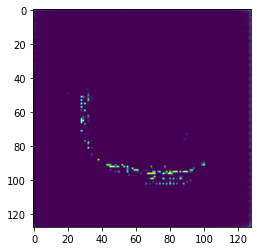

In [207]:
plt.imshow(pred[0][:, :, 0])

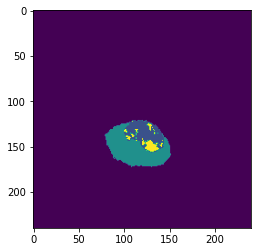

In [131]:
import matplotlib.pyplot as plt
plt.imshow(seg)

In [46]:
history.history

{'loss': [1.1112102270126343, 0.4273770749568939],
 'accuracy': [0.643875777721405, 0.9611085057258606],
 'one_hot_mean_io_u': [0.162858784198761, 0.2403409332036972],
 'one_hot_io_u': [0.6442953944206238, 0.961113691329956],
 'one_hot_io_u_1': [0.0, 0.0],
 'one_hot_io_u_2': [0.007139731198549271, 0.0002500144182704389],
 'one_hot_io_u_3': [0.0, 0.0],
 'weighted_f1': [0.4888043701648712, 0.8008794784545898],
 'precision': [1.0, 0.9833060503005981],
 'precision_1': [0.0, 0.0],
 'precision_2': [0.0, 0.0],
 'precision_3': [0.0, 0.0],
 'recall': [0.005293977912515402, 0.7690828442573547],
 'recall_1': [0.0, 0.0],
 'recall_2': [0.0, 0.0],
 'recall_3': [0.0, 0.0],
 'val_loss': [0.7661035656929016, 0.09657168388366699],
 'val_accuracy': [0.9624722599983215, 0.9846280217170715],
 'val_one_hot_mean_io_u': [0.24061806499958038, 0.24615700542926788],
 'val_one_hot_io_u': [0.9624722599983215, 0.9846280217170715],
 'val_one_hot_io_u_1': [0.0, 0.0],
 'val_one_hot_io_u_2': [0.0, 0.0],
 'val_one_hot_i

In [26]:
history = model.fit(train_dataset, epochs=1, steps_per_epoch=len(train_brains) * (dataloader.BRAIN_FRAMES//BATCH_SIZE), validation_data=val_dataset)

  1/768 [..............................] - ETA: 19:42:10 - loss: 0.9940 - accuracy: 0.6422 - one_hot_mean_io_u: 0.1645 - one_hot_io_u: 0.6461 - one_hot_io_u_1: 3.8336e-05 - one_hot_io_u_2: 0.0113 - one_hot_io_u_3: 4.0055e-04 - precision: 1.0000 - precision_1: 0.0000e+00 - precision_2: 0.0000e+00 - precision_3: 0.0000e+00 - recall: 4.4396e-05 - recall_1: 0.0000e+00 - recall_2: 0.0000e+00 - recall_3: 0.0000e+00

KeyboardInterrupt: 

In [22]:
model.evaluate()

228/228 [==============================] - 195s 854ms/step - loss: 0.0924 - accuracy: 0.9782


[0.09240186959505081, 0.9781610369682312]